# Deep Learning and Its Applications to Signal and
## Image Processing and Analysis
### 361.2.1120
### Home Work 1

Alon Zeltser -
Nadav Amir - 308339860


In [2]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from torchviz import make_dot
from torchsummary import summary
import matplotlib.pyplot as plt
import datetime
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import random
import torchvision
from torchvision import transforms
from torchmetrics.classification import MulticlassF1Score

BATCH_SIZE = 256
CLASSES_COUNT = 10
LEARNING_RATE = 0.001
EPOCHS_COUNT = 20 # changed to 25 to oveserve overfit in section 2 (I think that accroding to forum conditions need to be the same)
TRAIN_SPLIT_RATIO = 0.8 # 0.8 - regular split. ~0.002 for receiving an overfit
MNIST_IMAGE_DIM = 28

DEBUG = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used for learning: {DEVICE}")

class MyNet(nn.Module):
    def __init__(self, classes_count,dropout=False):
        super(MyNet, self).__init__()
        self.dropout = dropout
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # in: 28X28, out: 28X28X16
        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,
                                padding=1)  # in: 28X28X16, out: 28X28X32
        self.mp_1 = nn.MaxPool2d(kernel_size=2, stride=2)  # in: 28X28X32, out: 14X14X32
        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                                padding=1)  # in: 14X14X32, out: 14X14X64
        self.linear_1 = nn.Linear(3136, 300)  # in: 7X7X32, out: 14X14X64
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(300, classes_count)
        self.sm_1 = nn.Softmax(dim=1)
        self.dropout_fc = nn.Dropout(p=0.05)

    def forward(self, x):
        out = self.relu_1(self.conv_1(x))

        if self.dropout:
            out = self.dropout_fc(out)

        out = self.relu_1(self.conv_2(out))

        if self.dropout:
            out = self.dropout_fc(out)

        out = self.mp_1(out)

        if self.dropout:
            out = self.dropout_fc(out)

        out = self.relu_1(self.conv_3(out))
        out = self.mp_1(out)
        if self.dropout:
            out = self.dropout_fc(out)


        out = out.reshape(out.size(0), -1)
        out = self.relu_1(self.linear_1(out))

        if self.dropout:
            out = self.dropout_fc(out)

        out = self.linear_2(out)
        return out

def visualize_model_as_graph(model:MyNet):
    dummy_input = torch.randn(1, 1, MNIST_IMAGE_DIM, MNIST_IMAGE_DIM) #single MNIST image size
    dummy_result = model(dummy_input)
    dot = make_dot(dummy_result, params=dict(model.named_parameters()))
    print(type(dot))
    print(dot)
    dot.render("model_graph", format='png')

def load_train_set(origin_train_data, split_ratio, batch_size,force_balanced_categories=True, augmentation=False,
                   augmentation_params=None):
    train_size = int(len(origin_train_data) * split_ratio)
    validation_size = len(origin_train_data) - train_size
    if force_balanced_categories:
        targets = origin_train_data.targets
        splitter = StratifiedShuffleSplit(n_splits=1, test_size=validation_size / (train_size + validation_size))
        for train_idx, val_idx in splitter.split(X=range(len(targets)), y=targets):
            train_set = Subset(origin_train_data, train_idx)
            validation_set = Subset(origin_train_data, val_idx)
    else:
        train_set, validation_set = random_split(origin_train_data, [train_size, validation_size])
    train_transform = None

    # TODO: DEPRECATED - Did not work on Nadav's machine. rewritten as different function using https://discuss.pytorch.org/t/transforms-on-subset/166836
    if augmentation:
        rotation_limit = augmentation_params["rotation limit"]
        probability = augmentation_params["probability"]
        noise_amp = augmentation_params["noise amplitude"]
        scale_lim = augmentation_params["scale_limit"]
        train_transform = transforms.Compose([
            transforms.RandomApply([transforms.RandomRotation(degrees=(-rotation_limit, rotation_limit))], p = probability),
            transforms.RandomHorizontalFlip(p = probability),
            transforms.ToTensor(),
            transforms.RandomApply([transforms.Lambda(lambda img: torch.clamp(img + torch.randn_like(img) * noise_amp, 0, 1))], p=probability),
            transforms.RandomResizedCrop(size=(MNIST_IMAGE_DIM,MNIST_IMAGE_DIM), scale=(scale_lim, 1.0))
        ])
    else:
        train_transform = transforms.Compose([ToTensor()])
    validation_transform = transforms.Compose([ToTensor()])
    train_set.dataset.transform = train_transform
    validation_set.dataset.transform = validation_transform
    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)

    if DEBUG:
        # Verify categories are balanced:
        sets_dict = {"Train": train_set, "Validation": validation_set}
        visualize_data_splits(sets_dict)
    return train_loader, validation_loader

def load_aug_train_set(origin_train_data, split_ratio, batch_size,augmentation_params=None):
    class MyDataset(Dataset):
        def __init__(self, subset, transform=None):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, index):
            x, y = self.subset[index]
            if self.transform:
                x = self.transform(x)
            return x, y

        def __len__(self):
            return len(self.subset)

    train_size = int(len(origin_train_data) * split_ratio)
    validation_size = len(origin_train_data) - train_size
    train_set, validation_set = random_split(origin_train_data, [train_size, validation_size])


    rotation_limit = augmentation_params["rotation limit"]
    probability = augmentation_params["probability"]
    noise_amp = augmentation_params["noise amplitude"]
    scale_lim = augmentation_params["scale_limit"]
    train_transform = transforms.Compose([
        # PIL-based augmentations:
        transforms.RandomApply([transforms.RandomRotation(degrees=(-rotation_limit, rotation_limit))], p=probability),
        transforms.RandomHorizontalFlip(p=probability),
        transforms.RandomApply([transforms.RandomResizedCrop(size=(MNIST_IMAGE_DIM, MNIST_IMAGE_DIM), scale=(scale_lim, 1.0))],p=probability),
        # Convert PIL image to tensor:
        transforms.ToTensor(),
        # Tensor-based augmentation:
        transforms.RandomApply([
            transforms.Lambda(lambda img: torch.clamp(img + torch.randn_like(img) * noise_amp, 0, 1))
        ], p=probability)
    ])

    aug_train_set = MyDataset(train_set, transform=train_transform)
    aug_validation_set = MyDataset(validation_set, transform=transforms.Compose([ToTensor()]))

    train_loader = DataLoader(dataset=aug_train_set, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(dataset=aug_validation_set, batch_size=batch_size, shuffle=False)

    batch = next(iter(train_loader))
    images = batch[0]  # Assumes the batch is a tuple (images, labels)

    # Create a grid of images (adjust nrow as needed)
    grid_img = torchvision.utils.make_grid(images, nrow=5)

    # Plot the grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Training Batch Images")
    plt.show()

    if DEBUG:
        # Verify categories are balanced:
        sets_dict = {"Train": train_set, "Validation": validation_set}
        visualize_data_splits(sets_dict)
    return train_loader, validation_loader

def plot_categories_histograms(set,header):
    # Extract class labels from the original dataset (Subset stores indices)
    # Supports subset or full dataset via try except mechanism on input
    try:
        labels = [set.dataset.targets[i] for i in set.indices]
    except:
        labels = [set.targets[i] for i in range(len(set.targets))]
    # Creating histogram dicts:
    counting_dict={}
    for k in range(CLASSES_COUNT):
        counting_dict[k]=0
    # Count occurrences of each class
    for i,value in enumerate(np.array(labels)):
        counting_dict[value] +=1

    # Extract class indices and corresponding counts
    classes = list(counting_dict.keys())
    counts = [counting_dict[k] for k in classes]

    total = sum(counts)
    percentages = [count / total * 100 for count in counts]

    # Plotting training set histogram
    plt.figure(figsize=(8, 4))
    bars = plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'{header} Set Class Distribution')
    plt.xticks(classes)
    plt.tight_layout()

    # Add percentage labels on top of bars
    for bar, percent in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height , f'{percent:.1f}%',
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_train_progress(train_losses, validation_losses, secondary_axes=True):
    assert(len(train_losses) == len(validation_losses))
    x1 = np.arange(len(train_losses))
    validation_x_values = x1[~np.isnan(validation_losses)]
    validation_y_values = np.array(validation_losses)[~np.isnan(validation_losses)]

    filtered = gaussian_filter1d(train_losses, sigma=2)

    fig, ax = plt.subplots()  # Changed 'fix' to 'fig' for clarity
    ax.plot(x1, filtered, label='Train Loss', linestyle="solid", color="blue")
    ax.plot(validation_x_values, validation_y_values, linestyle='solid', color="red", zorder=4, label='Validation Loss')
    ax.set_xlabel("Mini Batch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.set_title("Train vs. Validation Loss Progress")

    if secondary_axes:
        epoch_numbers = np.arange(0, len(validation_x_values) + 1)
        validation_x_values_with_0 = np.insert(validation_x_values, 0, 0)
        ax2 = ax.twiny()  # twin x-axis
        ax2.set_xlim(ax.get_xlim())  # align the secondary x-axis with the primary
        ax2.set_xticks(validation_x_values_with_0)
        ax2.set_xticklabels(epoch_numbers)
        ax2.set_xlabel("Epoch")


    # Adjust layout so nothing is clipped
    plt.tight_layout()
    filename = f"image_progress_{datetime.datetime.now()}.png".replace('-', '_').replace(':', '_').replace(' ', "_")
    plt.savefig(filename, bbox_inches='tight')
    plt.show()

def plot_conf_matrix(all_labels, all_predicted):
    sklrn_conf_mat = confusion_matrix(np.array(all_labels), np.array(all_predicted))
    normalized_conf_mat = sklrn_conf_mat.astype('float') / sklrn_conf_mat.sum(axis=1)[:, np.newaxis]

    sns.heatmap(normalized_conf_mat, annot=True, fmt=".2f", cmap="Greens", xticklabels=range(CLASSES_COUNT),
                yticklabels=range(CLASSES_COUNT))
    plt.xlabel("Predictaded")
    plt.ylabel("True Labels")
    plt.title("Test Results: Confusion Matrix")
    plt.savefig(
        f"confusion_matrix_{datetime.datetime.now()}.png".replace('-', '_').
        replace(':', '_').replace(' ', "_"))
    plt.show()

def plot_f1_scores(all_predicted, all_labels):
    f1 = MulticlassF1Score(num_classes=CLASSES_COUNT, average=None)
    f1_score = f1(torch.tensor(all_predicted), torch.tensor(all_labels))
    class_names = [str(i) for i in range(10)]
    plt.figure(figsize=(8, 5))
    plt.bar(class_names, f1_score, alpha=0.7, edgecolor='black')
    plt.xlabel("Classes")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score per Class. Macro Value:{np.average(f1_score):.4f}")
    for i, v in enumerate(f1_score):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')
    plt.ylim(0, 1.1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    print(f1_score)

def load_test_set(test_data, batch_size):
    return DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

def train(model:MyNet, train_data,
          split_ratio, batch_size, classes_count, learning_rate,
          augmentation=False, augmentation_params=None,patience=False,l2=0):
    print("loading the set into train and validation")
    if augmentation:
        train_loader, validation_loader = load_aug_train_set(train_data, split_ratio, batch_size,
                                                         augmentation_params=augmentation_params)
    else:
        train_loader, validation_loader = load_train_set(train_data, split_ratio, batch_size)
    loss_function = nn.CrossEntropyLoss()
    if l2>0:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=l2)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    steps_count = len(train_loader)
    train_losses = []
    validation_losses = []

    # early stopping params:
    if patience>0:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_path = "best_model.pth"

    for epoch in range(EPOCHS_COUNT):
        #train the epoch
        print(f"starting epoch {epoch+1}")
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            validation_losses.append(np.nan)
            if i % 50 == 0:
                print(f"Epoch {epoch+1}/{EPOCHS_COUNT}, step {i+1}/{steps_count}, current loss:{loss.item()}")
        print(f"Epoch {epoch+1} / {EPOCHS_COUNT} is done. Loss:{loss.item()}")
        #validate the epoch
        with torch.no_grad():
            correct_count = 0
            total_images = 0
            acc_loss = 0
            acc_items = 0
            for i, (images, labels) in enumerate(validation_loader):
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)
                outputs = model(images)
                val, predicted = torch.max(outputs.data, dim=1)
                total_images += len(images)
                correct = (predicted == labels).sum().item()
                correct_count += correct
                loss = loss_function(outputs, labels)
                batch_size = images.size(0)
                acc_loss += loss.item() * batch_size
                acc_items += batch_size
                del images, labels, outputs
            val_loss = (acc_loss / acc_items)
            validation_losses[-1] = val_loss
            print(f"validation accuracy ratio: {correct_count / total_images}")

            # early stopping
            if patience>0:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), best_model_path)  # Save best model
                    print(f"Validation loss improved to {val_loss:.4f}. Model checkpoint saved.")
                else:
                    patience_counter += 1
                    print(f"No improvement observed. Patience counter: {patience_counter}/{patience}")
                    if patience_counter >= patience:
                        print("Early stopping triggered. Loading best model and stopping training")
                        print(f"model stooped at epoch {epoch}")
                        model.load_state_dict(torch.load(best_model_path))
                        break

            # TODO: I comment this out because it sometimes stops the training
            # Todo: (I think the break command stops training and assumed this is not your original intention)
            # if correct_count / total_images > 0.99:
            #     print("Stopping the training")
            #     break
    plot_train_progress(train_losses, validation_losses)

def test(model: MyNet, test_data: object, batch_size: object):
    with torch.no_grad():
        correct_cout = 0
        total_count = 0
        all_predicted = []
        all_labels = []
        test_set = load_test_set(test_data, batch_size=batch_size)
        for images, labels in test_set:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            vals, predicted = torch.max(outputs.data, 1)
            all_predicted += predicted.tolist()
            all_labels += labels.tolist()
            total_count += len(labels)
            correct_cout += (predicted == labels).sum().item()
            del images, labels, outputs
        print(f"Test results: accuracy of {correct_cout / total_count}")
        plot_conf_matrix(all_labels, all_predicted)
        plot_f1_scores(all_predicted, all_labels)

def load_mnist():
    train_data = datasets.MNIST(root='./mnist/', download=True, train=True)
    test_data = datasets.MNIST(root='./mnist/', download=True, train=False, transform=ToTensor())
    return train_data, test_data

def inspect_minist_data(train_data, test_data):
    print(type(train_data))
    print(type(test_data))

    image, label = train_data[0]
    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(test_data.classes[label])
    plt.show()

def visualize_data_splits(sets_dict):
    for key, dataset in sets_dict.items():
        plot_categories_histograms(dataset, key)
    return

def visualize_augmentation_example(train_data):
    original_image,_ = train_data[138]
    augmentations = {
        "Original": transforms.ToTensor(),
        "Rotated 30 Degrees": transforms.RandomRotation((30,30)),
        "Horizontal Flip": transforms.RandomHorizontalFlip(p=1),
        "Added Gaussian Noise":
            transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda img: torch.clamp(img + torch.randn_like(img) * 0.2, 0, 1))
                ]),
        "Random Crop 60% and \n Resize to Original Size": transforms.RandomResizedCrop(size=(MNIST_IMAGE_DIM, MNIST_IMAGE_DIM), scale=(0.6, 0.6))
    }
    transformed_images = [augmentations[key](original_image) for key in augmentations]
    transformed_images = [img.squeeze() if isinstance(img, torch.Tensor) else np.array(img) for img in transformed_images]

    fig, axes = plt.subplots(1, 5, figsize=(18,6))

    for i, (key, image) in enumerate(zip(augmentations.keys(), transformed_images)):
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(key)
        axes[i].axis("off")
    plt.show()

Device used for learning: cuda


SEIF 1

loading data set
loading the set into train and validation
starting epoch 1
Epoch 1/20, step 1/188, current loss:2.3039920330047607
Epoch 1/20, step 51/188, current loss:0.28646567463874817
Epoch 1/20, step 101/188, current loss:0.16892991960048676
Epoch 1/20, step 151/188, current loss:0.14755211770534515
Epoch 1 / 20 is done. Loss:0.03771565854549408
validation accuracy ratio: 0.9691666666666666
starting epoch 2
Epoch 2/20, step 1/188, current loss:0.08232591301202774
Epoch 2/20, step 51/188, current loss:0.08898991346359253
Epoch 2/20, step 101/188, current loss:0.15170834958553314
Epoch 2/20, step 151/188, current loss:0.05906565487384796
Epoch 2 / 20 is done. Loss:0.15097375214099884
validation accuracy ratio: 0.9815
starting epoch 3
Epoch 3/20, step 1/188, current loss:0.03505244106054306
Epoch 3/20, step 51/188, current loss:0.09752544015645981
Epoch 3/20, step 101/188, current loss:0.04042553901672363
Epoch 3/20, step 151/188, current loss:0.02525305561721325
Epoch 3 / 20 is do

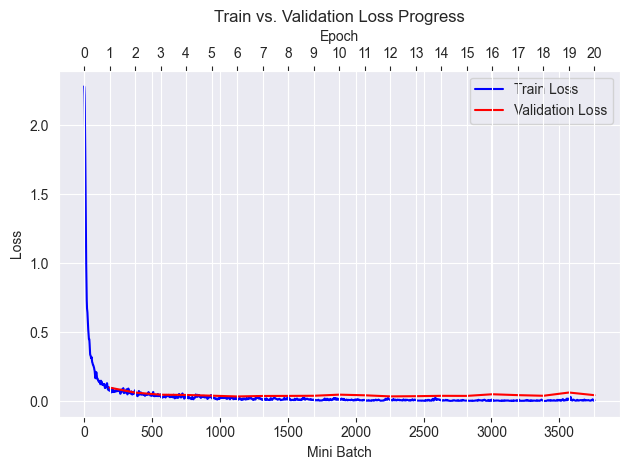

testing...
Test results: accuracy of 0.9901


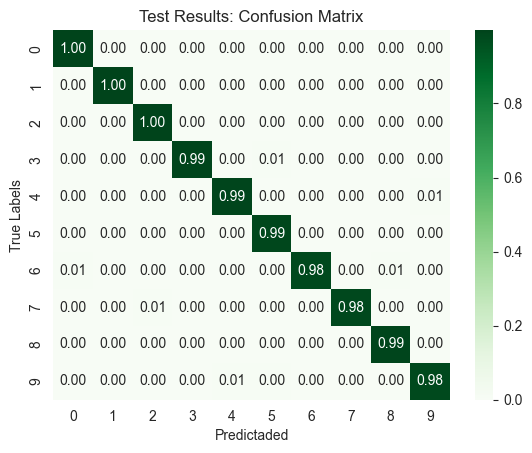

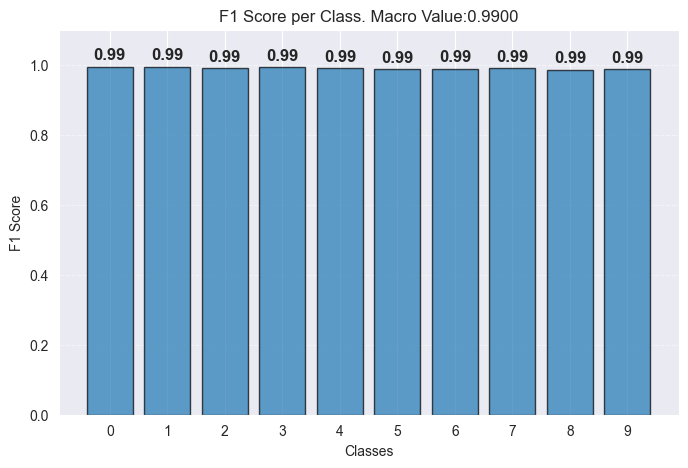

tensor([0.9944, 0.9947, 0.9894, 0.9935, 0.9903, 0.9871, 0.9884, 0.9902, 0.9852,
        0.9866])
done


In [5]:
DEBUG = False
TRAIN_SPLIT_RATIO = 0.8
print("loading data set")
train_data, test_data = load_mnist()
model = MyNet(CLASSES_COUNT).to(DEVICE)
train(model, train_data, TRAIN_SPLIT_RATIO, BATCH_SIZE, CLASSES_COUNT, LEARNING_RATE)
print("testing...")
test(model,test_data, BATCH_SIZE)
print("done")

SEIF 2

loading data set


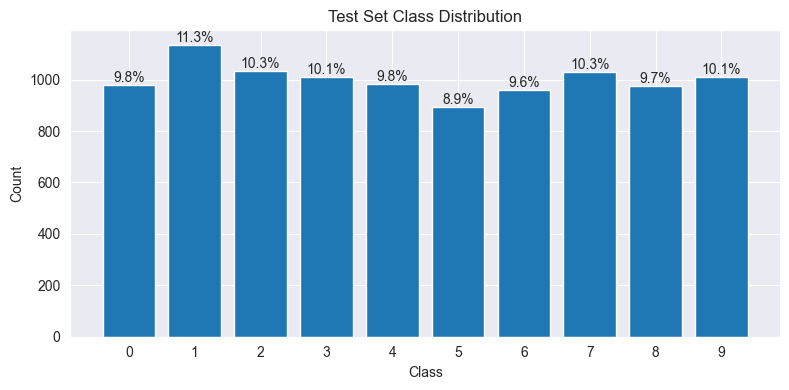

loading the set into train and validation


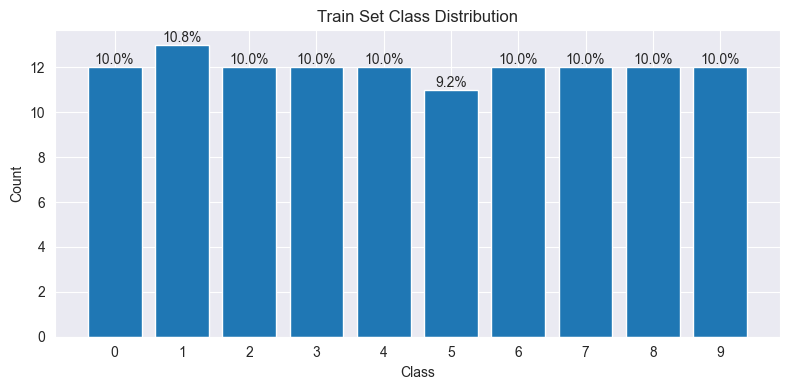

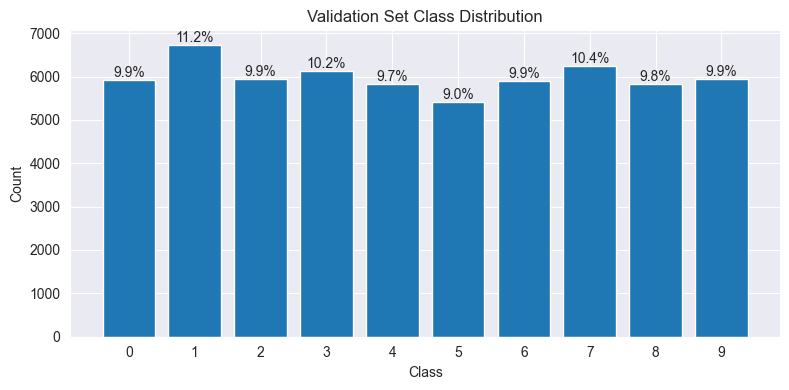

starting epoch 1
Epoch 1/20, step 1/1, current loss:2.3037610054016113
Epoch 1 / 20 is done. Loss:2.3037610054016113
validation accuracy ratio: 0.29906479625918503
starting epoch 2
Epoch 2/20, step 1/1, current loss:2.2914226055145264
Epoch 2 / 20 is done. Loss:2.2914226055145264
validation accuracy ratio: 0.36917167668670675
starting epoch 3
Epoch 3/20, step 1/1, current loss:2.270001173019409
Epoch 3 / 20 is done. Loss:2.270001173019409
validation accuracy ratio: 0.45
starting epoch 4
Epoch 4/20, step 1/1, current loss:2.240021228790283
Epoch 4 / 20 is done. Loss:2.240021228790283
validation accuracy ratio: 0.5464595858383433
starting epoch 5
Epoch 5/20, step 1/1, current loss:2.197658061981201
Epoch 5 / 20 is done. Loss:2.197658061981201
validation accuracy ratio: 0.5907815631262525
starting epoch 6
Epoch 6/20, step 1/1, current loss:2.1397194862365723
Epoch 6 / 20 is done. Loss:2.1397194862365723
validation accuracy ratio: 0.6291583166332665
starting epoch 7
Epoch 7/20, step 1/1, c

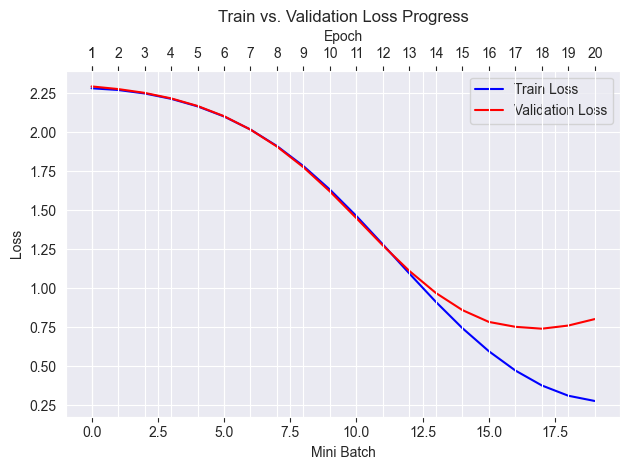

testing...
Test results: accuracy of 0.7645


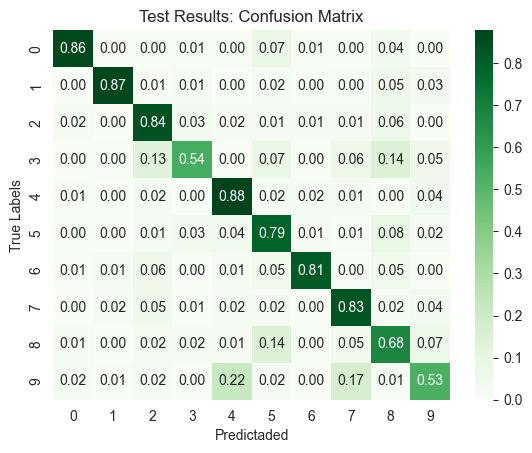

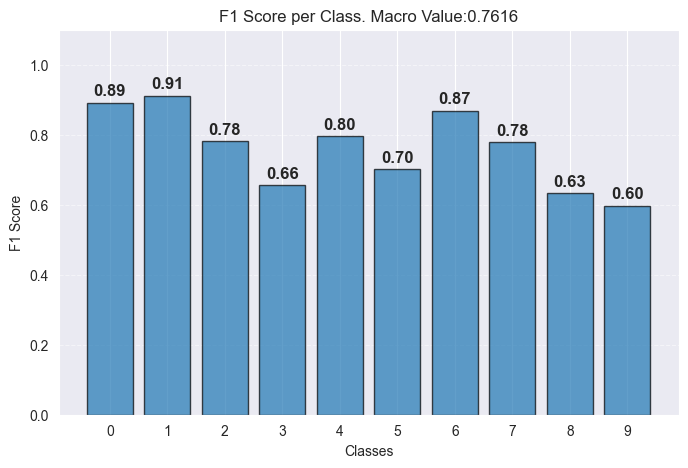

tensor([0.8918, 0.9120, 0.7814, 0.6554, 0.7952, 0.7017, 0.8686, 0.7790, 0.6336,
        0.5972])
done


In [11]:
DEBUG = True
TRAIN_SPLIT_RATIO = 0.002
print("loading data set")
train_data, test_data = load_mnist()
model = MyNet(CLASSES_COUNT).to(DEVICE)
visualize_data_splits({"Test":test_data})
train(model, train_data, TRAIN_SPLIT_RATIO, BATCH_SIZE, CLASSES_COUNT, LEARNING_RATE)
print("testing...")
test(model,test_data, BATCH_SIZE)
print("done")

SEIF 3 - Early stopping

loading data set
loading the set into train and validation
starting epoch 1
Epoch 1/20, step 1/1, current loss:2.3027567863464355
Epoch 1 / 20 is done. Loss:2.3027567863464355
validation accuracy ratio: 0.18271543086172345
Validation loss improved to 2.2902. Model checkpoint saved.
starting epoch 2
Epoch 2/20, step 1/1, current loss:2.2866601943969727
Epoch 2 / 20 is done. Loss:2.2866601943969727
validation accuracy ratio: 0.4340514362057448
Validation loss improved to 2.2671. Model checkpoint saved.
starting epoch 3
Epoch 3/20, step 1/1, current loss:2.257633686065674
Epoch 3 / 20 is done. Loss:2.257633686065674
validation accuracy ratio: 0.540998663994656
Validation loss improved to 2.2336. Model checkpoint saved.
starting epoch 4
Epoch 4/20, step 1/1, current loss:2.2169203758239746
Epoch 4 / 20 is done. Loss:2.2169203758239746
validation accuracy ratio: 0.5366900467601871
Validation loss improved to 2.1837. Model checkpoint saved.
starting epoch 5
Epoch 5/20, step 1/1, current loss

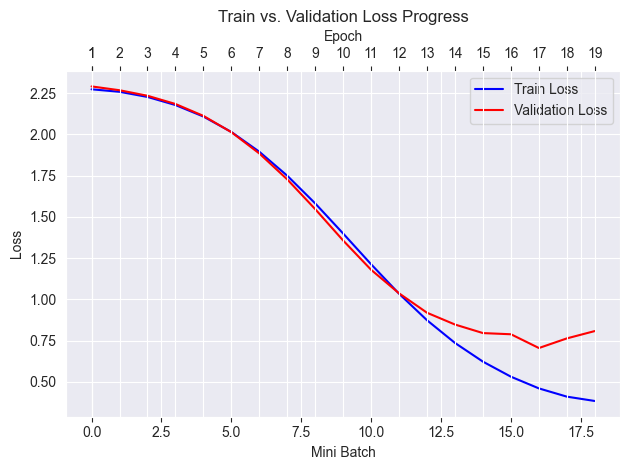

testing...
Test results: accuracy of 0.7733


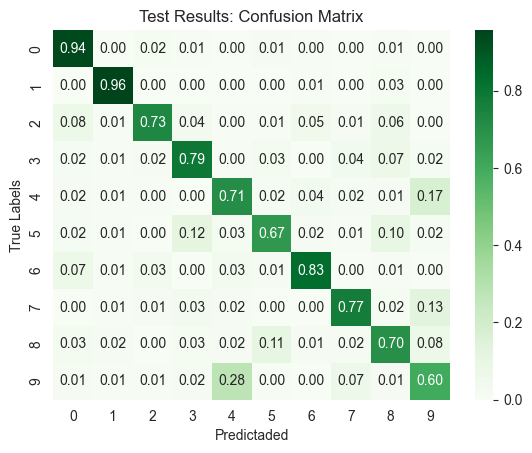

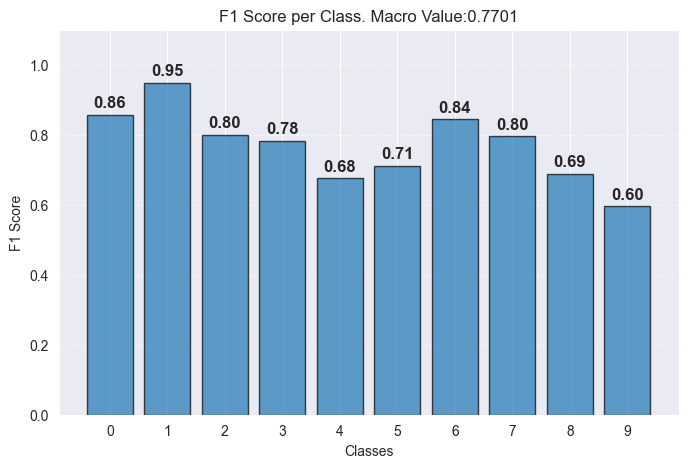

tensor([0.8573, 0.9489, 0.7998, 0.7833, 0.6754, 0.7117, 0.8443, 0.7960, 0.6882,
        0.5964])
done


In [14]:
DEBUG = False
patience = 2
TRAIN_SPLIT_RATIO = 0.002
print("loading data set")
train_data, test_data = load_mnist()
model = MyNet(CLASSES_COUNT).to(DEVICE)
train(model, train_data, TRAIN_SPLIT_RATIO, BATCH_SIZE, CLASSES_COUNT, LEARNING_RATE,patience=2)
print("testing...")
test(model,test_data, BATCH_SIZE)
print("done")

Dropout

loading data set
loading the set into train and validation
starting epoch 1
Epoch 1/20, step 1/1, current loss:2.303105115890503
Epoch 1 / 20 is done. Loss:2.303105115890503
validation accuracy ratio: 0.14483967935871744
starting epoch 2
Epoch 2/20, step 1/1, current loss:2.2909345626831055
Epoch 2 / 20 is done. Loss:2.2909345626831055
validation accuracy ratio: 0.3254509018036072
starting epoch 3
Epoch 3/20, step 1/1, current loss:2.267756223678589
Epoch 3 / 20 is done. Loss:2.267756223678589
validation accuracy ratio: 0.36735136940547763
starting epoch 4
Epoch 4/20, step 1/1, current loss:2.2342076301574707
Epoch 4 / 20 is done. Loss:2.2342076301574707
validation accuracy ratio: 0.39672678690714763
starting epoch 5
Epoch 5/20, step 1/1, current loss:2.184730052947998
Epoch 5 / 20 is done. Loss:2.184730052947998
validation accuracy ratio: 0.4367401469605878
starting epoch 6
Epoch 6/20, step 1/1, current loss:2.1210925579071045
Epoch 6 / 20 is done. Loss:2.1210925579071045
validation a

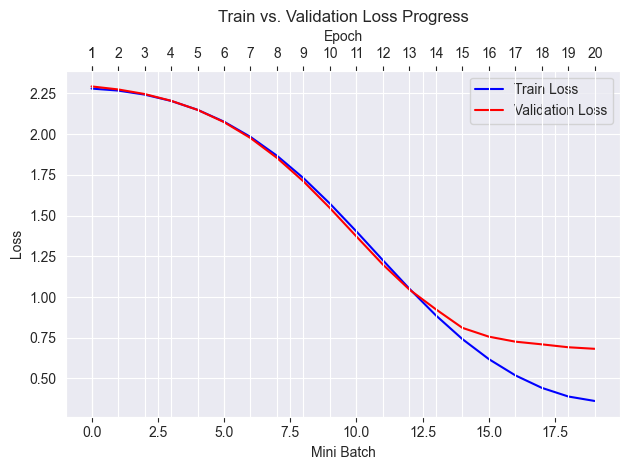

testing...
Test results: accuracy of 0.8052


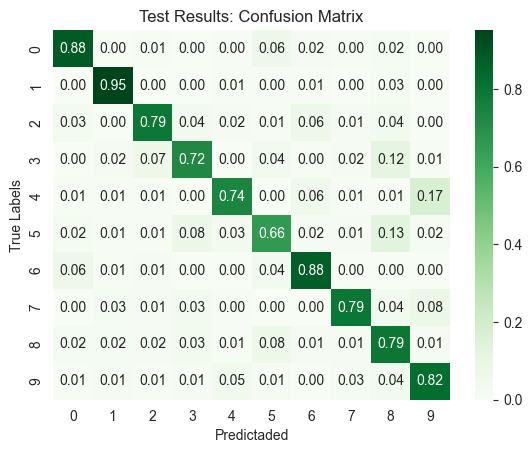

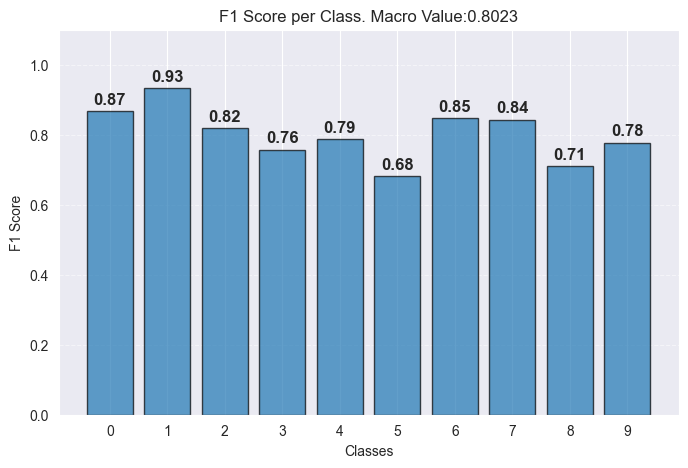

tensor([0.8679, 0.9330, 0.8183, 0.7569, 0.7880, 0.6818, 0.8472, 0.8434, 0.7097,
        0.7772])
done


In [16]:
DEBUG = False
TRAIN_SPLIT_RATIO = 0.002
print("loading data set")
train_data, test_data = load_mnist()
model = MyNet(CLASSES_COUNT,dropout=True).to(DEVICE)
train(model, train_data, TRAIN_SPLIT_RATIO, BATCH_SIZE, CLASSES_COUNT, LEARNING_RATE)
print("testing...")
test(model,test_data, BATCH_SIZE)
print("done")

SEIF 3 - L2 Regularization

loading data set
loading the set into train and validation
starting epoch 1
Epoch 1/20, step 1/1, current loss:2.303277015686035
Epoch 1 / 20 is done. Loss:2.303277015686035
validation accuracy ratio: 0.37518370073480295
starting epoch 2
Epoch 2/20, step 1/1, current loss:2.280717134475708
Epoch 2 / 20 is done. Loss:2.280717134475708
validation accuracy ratio: 0.3982631930527722
starting epoch 3
Epoch 3/20, step 1/1, current loss:2.24639630317688
Epoch 3 / 20 is done. Loss:2.24639630317688
validation accuracy ratio: 0.4720774883099532
starting epoch 4
Epoch 4/20, step 1/1, current loss:2.1945486068725586
Epoch 4 / 20 is done. Loss:2.1945486068725586
validation accuracy ratio: 0.5419004676018704
starting epoch 5
Epoch 5/20, step 1/1, current loss:2.121380567550659
Epoch 5 / 20 is done. Loss:2.121380567550659
validation accuracy ratio: 0.5885437541750167
starting epoch 6
Epoch 6/20, step 1/1, current loss:2.022402286529541
Epoch 6 / 20 is done. Loss:2.022402286529541
validation accuracy 

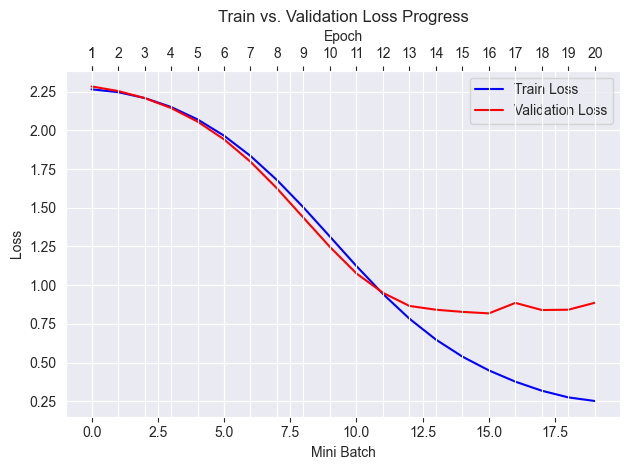

testing...
Test results: accuracy of 0.7871


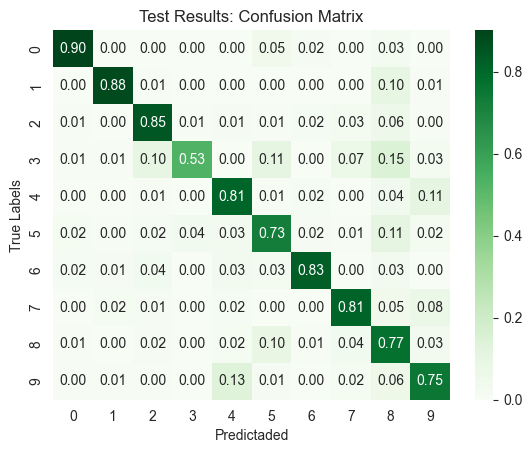

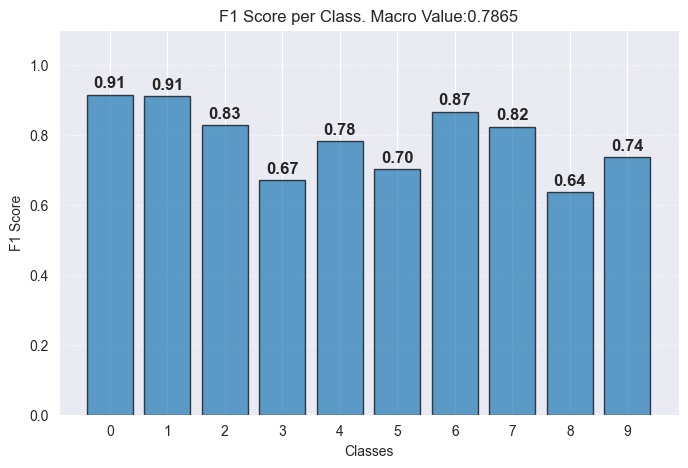

tensor([0.9141, 0.9108, 0.8274, 0.6696, 0.7819, 0.7017, 0.8655, 0.8228, 0.6359,
        0.7354])
done


In [17]:
DEBUG = False
TRAIN_SPLIT_RATIO = 0.002
print("loading data set")
train_data, test_data = load_mnist()
model = MyNet(CLASSES_COUNT).to(DEVICE)
l2 = 1e-3
train(model, train_data, TRAIN_SPLIT_RATIO, BATCH_SIZE, CLASSES_COUNT, LEARNING_RATE,l2=l2)
print("testing...")
test(model,test_data, BATCH_SIZE)
print("done")

SEIF 4

loading data set
creating the model


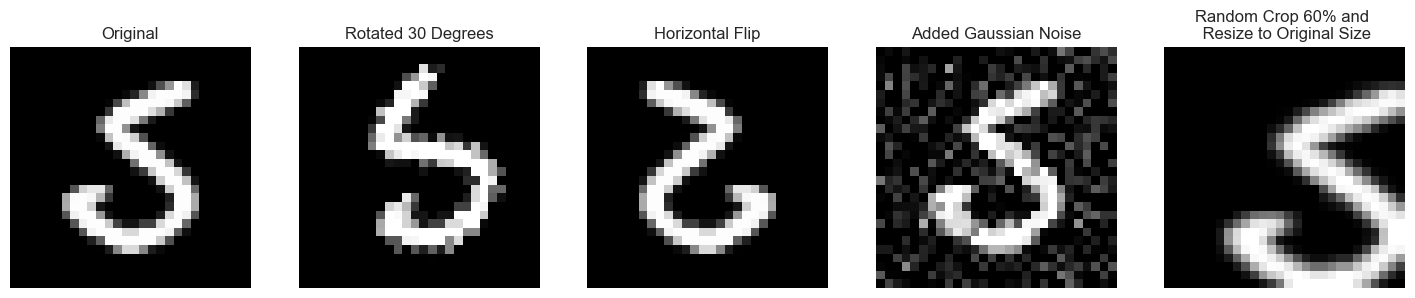

training...
loading the set into train and validation


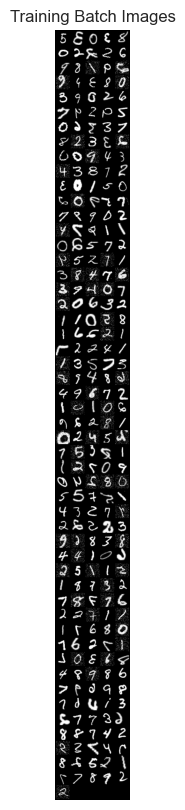

starting epoch 1
Epoch 1/20, step 1/188, current loss:2.303511142730713
Epoch 1/20, step 51/188, current loss:0.7784613370895386
Epoch 1/20, step 101/188, current loss:0.5137916803359985
Epoch 1/20, step 151/188, current loss:0.5106329321861267
Epoch 1 / 20 is done. Loss:0.25005367398262024
validation accuracy ratio: 0.9534166666666667
starting epoch 2
Epoch 2/20, step 1/188, current loss:0.3033391237258911
Epoch 2/20, step 51/188, current loss:0.29572007060050964
Epoch 2/20, step 101/188, current loss:0.1608237326145172
Epoch 2/20, step 151/188, current loss:0.3035321831703186
Epoch 2 / 20 is done. Loss:0.17017392814159393
validation accuracy ratio: 0.9723333333333334
starting epoch 3
Epoch 3/20, step 1/188, current loss:0.24705497920513153
Epoch 3/20, step 51/188, current loss:0.13462083041667938
Epoch 3/20, step 101/188, current loss:0.1657271385192871
Epoch 3/20, step 151/188, current loss:0.11842121928930283
Epoch 3 / 20 is done. Loss:0.1649901568889618
validation accuracy ratio: 

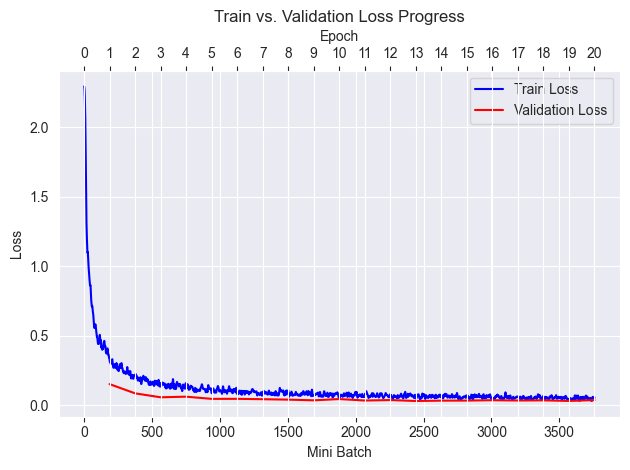

testing...
Test results: accuracy of 0.989


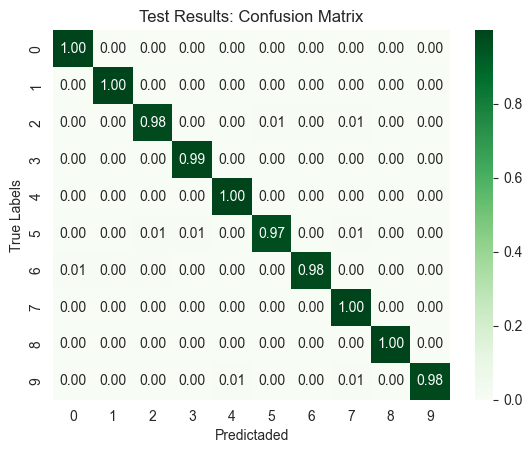

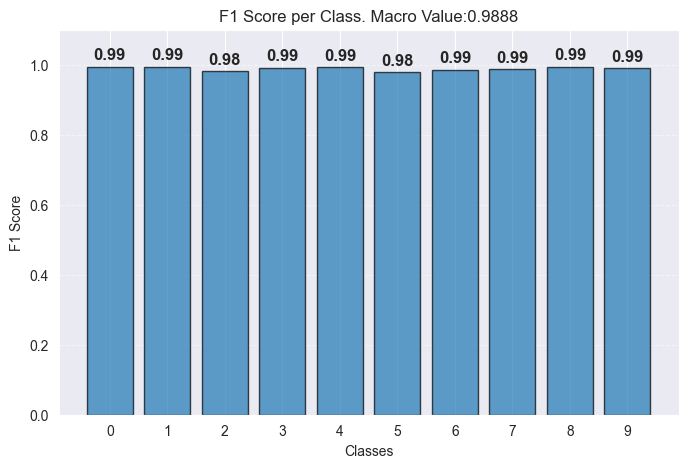

tensor([0.9939, 0.9943, 0.9811, 0.9911, 0.9924, 0.9780, 0.9858, 0.9875, 0.9949,
        0.9895])
done


In [20]:
TRAIN_SPLIT_RATIO = 0.8

print("loading data set")
train_data, test_data = load_mnist()
print("creating the model")


model = MyNet(CLASSES_COUNT).to(DEVICE)
visualize_augmentation_example(train_data)

print("training...")

augmentation = True
augmentation_params = {"rotation limit": 20, "probability": 0.25, "noise amplitude": 0.2, "scale_limit": 0.5}


train(model, train_data, TRAIN_SPLIT_RATIO, BATCH_SIZE, CLASSES_COUNT, LEARNING_RATE,
      augmentation=augmentation, augmentation_params=augmentation_params)

print("testing...")
test(model,test_data, BATCH_SIZE)
print("done")

